# 0. Install and Import dependencies

In [13]:
# !pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [14]:
# Gym stuff
import os
import yfinance as yf
import itertools
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from finta import TA
from ta.trend import MACD, CCIIndicator
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.volume import ChaikinMoneyFlowIndicator
from ta.volatility import KeltnerChannel
from ta.trend import IchimokuIndicator

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

# Processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import quantstats as qs

In [15]:
SEED = 5756

# Specify parameters
stock_name = 'MCD'

# Window size for training
train_window_size = 10
train_start = '2016-01-01'
train_end = '2023-09-01'

test_window_size = 10
learn_iteration = 100000

# Model parameters
model_name = 'A2C'

# Indicator parameters
sma_period = 10

# 1. Get Data

In [16]:

df = yf.Ticker(stock_name)
df = df.history(period="max")
df = df.loc[train_start:, ['Open', 'High', 'Low', 'Close', 'Volume']]
df

,Open,High,Low,Close,Volume
Date,,,,,
2016-01-04 00:00:00-05:00,95.790173,96.182324,94.662752,96.059776,9995000
2016-01-05 00:00:00-05:00,95.920878,97.407769,95.822839,97.383255,6314000
2016-01-06 00:00:00-05:00,96.402885,97.440438,96.247658,96.729675,6543800
2016-01-07 00:00:00-05:00,95.945393,96.378388,94.433986,94.491180,7477900
2016-01-08 00:00:00-05:00,94.564696,95.969892,94.164381,94.344116,6103400
...,...,...,...,...,...
2024-05-06 00:00:00-04:00,271.059998,271.880005,269.040009,269.299988,2481300
2024-05-07 00:00:00-04:00,270.040009,270.670013,266.989990,267.500000,3160000
2024-05-08 00:00:00-04:00,267.500000,268.929993,266.059998,268.489990,3259800


In [17]:
TRAIN_ENV_FRAME_BOUND = (train_window_size, df[train_start:train_end].shape[0])
TEST_ENV_FRAME_BOUND = (df[train_start:train_end].shape[0] + test_window_size, df.shape[0])

# 2.1 Add Custom Indicators

## 2.1.3. Calculate SMA, RSI and OBV

In [18]:
df['SMA'] = TA.SMA(df, sma_period)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

## 2.1.4. Create New Environments

In [19]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [20]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

# 3. Build Environment and Train

In [21]:
env2 = MyCustomEnv(df=df, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=train_window_size)
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [22]:
from sb3_contrib import RecurrentPPO

if model_name == 'A2C':
    model = A2C('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'RecurrentPPO':
    model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=SEED)
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'PPO':
    model = PPO('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'DQN':
    model = DQN('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)

# 4. Evaluation

In [23]:
env = MyCustomEnv(df=df, frame_bound=TEST_ENV_FRAME_BOUND, window_size=test_window_size)
observation, info = env.reset()
while True: 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': -21.48545653577196, 'total_profit': 0.5374350374988456, 'position': <Positions.Short: 0>}


In [24]:
total_profit = round(info['total_profit'], 2)

# Report output
trade_strategy_output = f".\\reports\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{train_window_size}_ITER{learn_iteration}_trade_strategy.png"
report_output = f".\\reports\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{train_window_size}_ITER{learn_iteration}_reports.html"

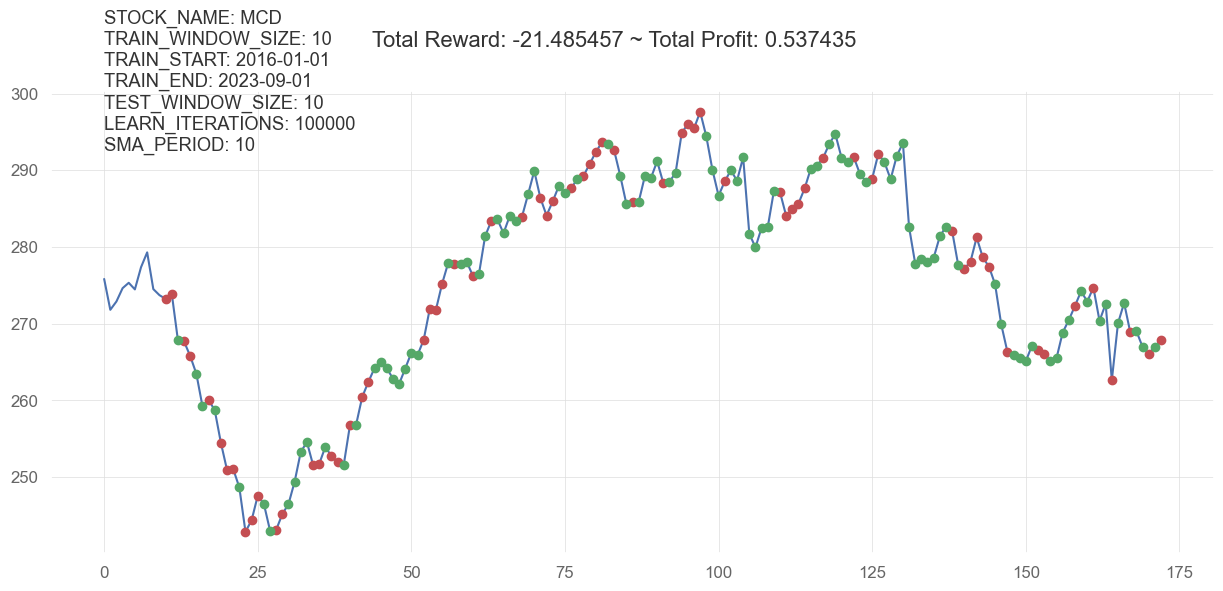

In [25]:
desc = f'STOCK_NAME: {stock_name}\nTRAIN_WINDOW_SIZE: {train_window_size}\nTRAIN_START: {train_start}\nTRAIN_END: {train_end}\nTEST_WINDOW_SIZE: {test_window_size}\nLEARN_ITERATIONS: {learn_iteration}\nSMA_PERIOD: {sma_period}'

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.text(0, env.prices.max() - 5, desc)
plt.savefig(trade_strategy_output)
plt.show()

# 5. QuantStats

                           Strategy
-------------------------  ----------
Start Period               2023-09-21
End Period                 2024-05-10
Risk-Free Rate             0.0%
Time in Market             23.0%

Cumulative Return          -46.26%
CAGR﹪                     -49.06%

Sharpe                     -6.09
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -5.26
Sortino                    -5.75
Smart Sortino              -4.97
Sortino/√2                 -4.07
Smart Sortino/√2           -3.51
Omega                      0.06

Max Drawdown               -46.26%
Longest DD Days            232
Volatility (ann.)          15.72%
Calmar                     -1.06
Skew                       -2.46
Kurtosis                   6.0

Expected Daily %           -0.38%
Expected Monthly %         -6.67%
Expected Yearly %          -26.69%
Kelly Criterion            -221.03%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.01%
Expected Shortfall (cVaR)  -2.01%

Max Consecuti

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-09-22,2024-05-10,2024-05-10,232,-46.256496,-44.163903


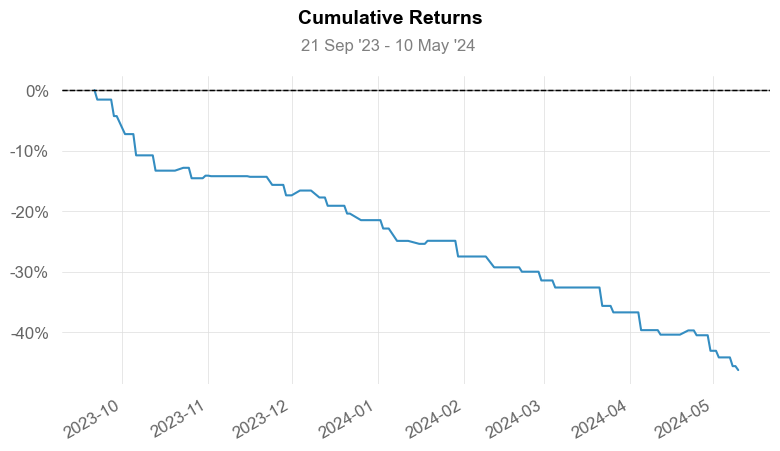

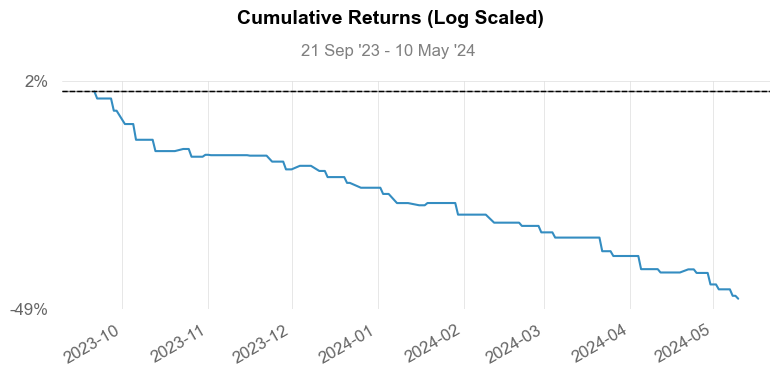

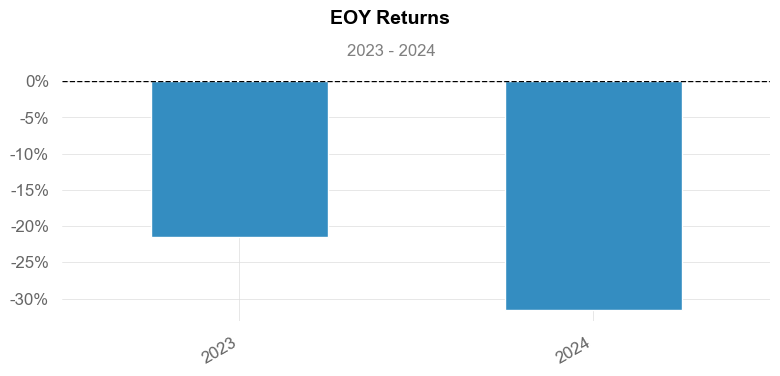

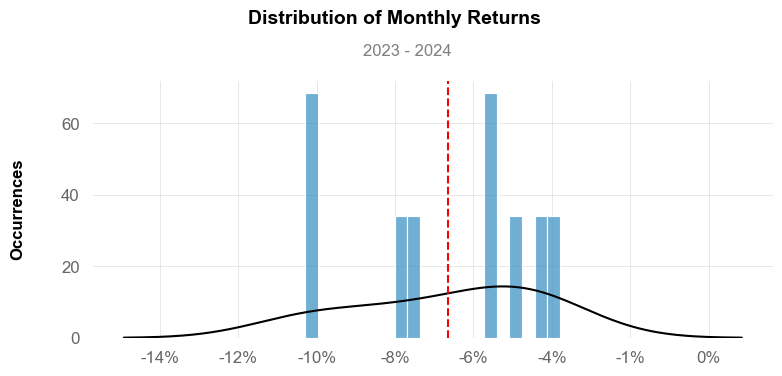

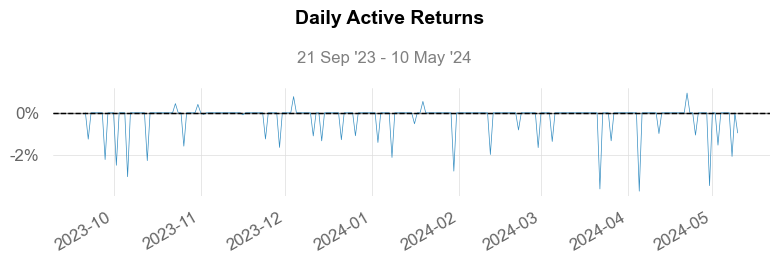

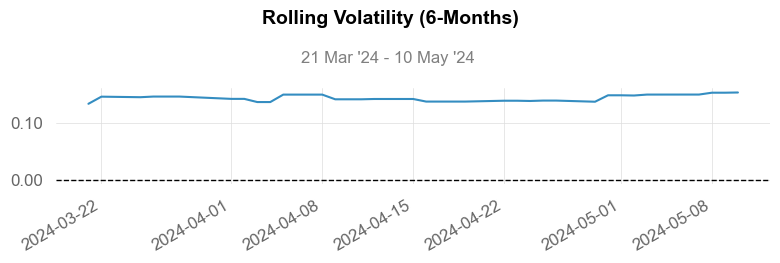

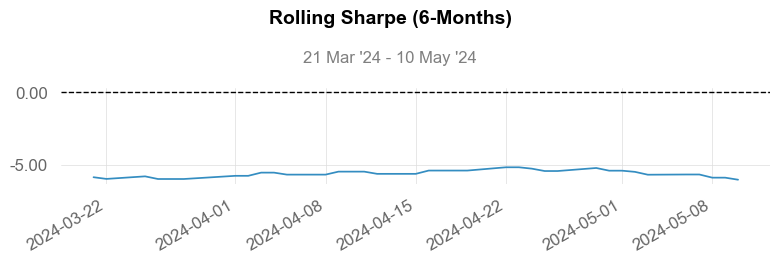

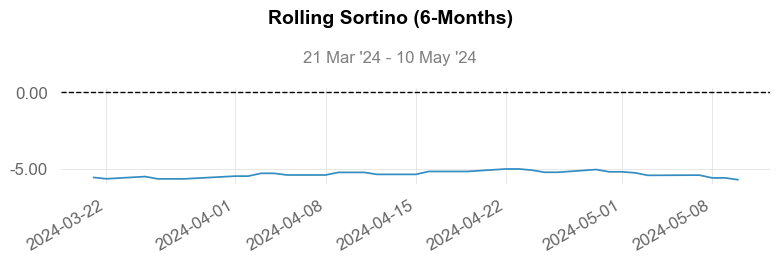

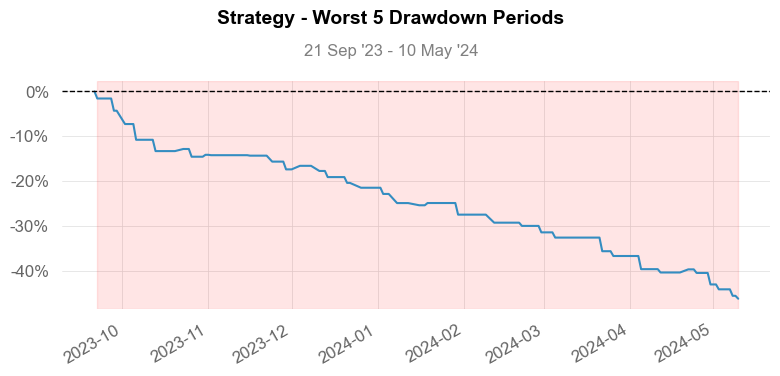

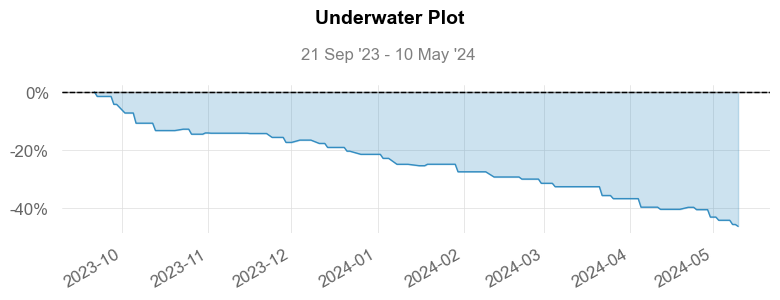

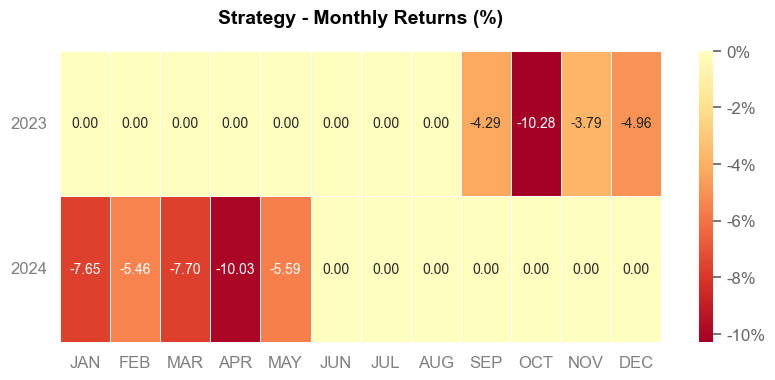

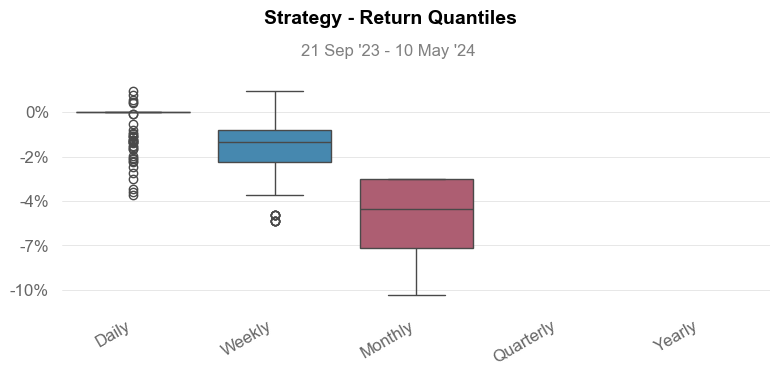

In [26]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output=report_output)

In [27]:
from typing import List
SEED = 5756
def analyze_stock(
    stock_name: str,
    window_size: int,
    train_start: str,
    train_end: str,
    learn_iteration: int,
    model_name: str,
    add_all: bool
) -> None:
    SEED = 5756
    df = yf.Ticker(stock_name)
    df = df.history(period="max")
    df = df.loc[train_start:, ['Open', 'High', 'Low', 'Close', 'Volume']]
    TRAIN_ENV_FRAME_BOUND = (window_size, df[train_start:train_end].shape[0])
    TEST_ENV_FRAME_BOUND = (df[train_start:train_end].shape[0] + window_size, df.shape[0])

    def add_all_features(df, add_all=True):
        if add_all:
            df['SMA'] = TA.SMA(df, period=10)  # Make sure SMA_PERIOD is defined

            # Add EMA
            df['EMA'] = TA.EMA(df, period=20)  # You can adjust the period as needed

            # Add RSI (you already have this)
            rsi = RSIIndicator(close=df['Close'])
            df['RSI'] = rsi.rsi()

            # Add MACD
            macd = MACD(close=df['Close'])
            df['MACD'] = macd.macd()

            # Add Bollinger Bands
            bollinger_bands = BollingerBands(close=df['Close'])
            df['BB_UPPER'] = bollinger_bands.bollinger_hband()
            df['BB_LOWER'] = bollinger_bands.bollinger_lband()
            df['BB_MIDDLE'] = bollinger_bands.bollinger_mavg()

            # Add Stochastic Oscillator
            # stoch = TA.STOCH(df)
            # df['STOCH_K'] = stoch['%K']
            # df['STOCH_D'] = stoch['%D']

            # Add Average True Range
            df['ATR'] = TA.ATR(df)

            # Add OBV (you already have this)
            df['OBV'] = TA.OBV(df)

            # Add Commodity Channel Index (CCI)
            cci = CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=20)
            df['CCI'] = cci.cci()

            # Add Rate of Change (ROC)
            df['ROC'] = TA.ROC(df, period=10)  # Default window is 10, adjust as needed

            # Add Chaikin Money Flow (CMF)
            cmf = ChaikinMoneyFlowIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=20)
            df['CMF'] = cmf.chaikin_money_flow()

            # Add Force Index
            df['Force_Index'] = (df['Close'].diff(1) * df['Volume']).fillna(0)

            # Add Keltner Channel
            keltner = TA.KC(df, period=20)  # Default window is 20, adjust as needed
            kc = KeltnerChannel(high=df['High'], low=df['Low'], close=df['Close'], window=20)
            # Add Keltner Channel values to DataFrame
            df['KC_UPPER'] = kc.keltner_channel_hband()
            df['KC_LOWER'] = kc.keltner_channel_lband()
            df['KC_MIDDLE'] = kc.keltner_channel_mband() 

            # Add Parabolic SAR
            # df['SAR'] = TA.SAR(df)  # Parameters can be adjusted for sensitivity

            # Add Ichimoku Cloud
            ichimoku = TA.ICHIMOKU(df)  # The window sizes can be adjusted if necessary
            from ta.trend import IchimokuIndicator

            # Add Ichimoku Indicator
            from ta.trend import IchimokuIndicator

            # Initialize Ichimoku Indicator using the 'High' and 'Low' columns of your DataFrame
            ichimoku_indicator = IchimokuIndicator(
                high=df['High'], 
                low=df['Low'], 
                window1=9, 
                window2=26, 
                window3=52,
                visual=False,  # If True, shift window2 (n2) period forward for visualization purposes
                fillna=False   # Set to True if you want to fill NA values
            )

            # Access the Ichimoku Cloud components
            df['ICHIMOKU_A'] = ichimoku_indicator.ichimoku_a()
            df['ICHIMOKU_B'] = ichimoku_indicator.ichimoku_b()
            df['ICHIMOKU_BASE_LINE'] = ichimoku_indicator.ichimoku_base_line()
            df['ICHIMOKU_CONVERSION_LINE'] = ichimoku_indicator.ichimoku_conversion_line()

            # Handle NaN values for newly added indicators
            df.fillna(0, inplace=True)

        return df

    df_augmented = add_all_features(df.copy(), add_all=add_all)

    def add_signals(env):
        start = env.frame_bound[0] - env.window_size
        end = env.frame_bound[1]
        prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
        signal_features = env.df.loc[:, :].to_numpy()[start:end]
        return prices, signal_features
    
    class MyCustomEnv(StocksEnv):
        _process_data = add_signals

    env2 = MyCustomEnv(df=df_augmented, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=window_size)
    env_maker = lambda: env2
    env = DummyVecEnv([env_maker])

    if model_name == 'A2C':
        model = A2C('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'RecurrentPPO':
        model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=SEED)
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'PPO':
        model = PPO('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'DQN':
        model = DQN('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)

    env = MyCustomEnv(df=df_augmented, frame_bound=TEST_ENV_FRAME_BOUND, window_size=window_size)
    observation, info = env.reset()
    while True: 
        observation = observation[np.newaxis, ...]
        action, _states = model.predict(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if done:
            print("info", info)
            break
    
    total_profit = round(info['total_profit'], 2)

    # Report output
    trade_strategy_output = f".\\{stock_name}\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{window_size}_ITER{learn_iteration}_FEAT{add_all}_trade_strategy.png"
    report_output = f".\\{stock_name}\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{window_size}_ITER{learn_iteration}_FEAT{add_all}_reports.html"

    desc = f'STOCK_NAME: {stock_name}\nwindow_size: {window_size}\nTRAIN_START: {train_start}\nTRAIN_END: {train_end}\nwindow_size: {window_size}\nLEARN_ITERATIONS: {learn_iteration}\nSMA_PERIOD: 10'
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.text(0, env.prices.max() - 5, desc)
    plt.savefig(trade_strategy_output)

    qs.extend_pandas()

    net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df_augmented.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
    returns = net_worth.pct_change().iloc[1:]

    qs.reports.html(returns, output=report_output)

    analysis = {
        'stock_name': stock_name,
        'window_size': window_size,
        'train_start': train_start,
        'train_end': train_end,
        'learn_iteration': learn_iteration,
        'model_name': model_name,
        'add_all': add_all,
        'total_profit': total_profit
    }
    return analysis

info {'total_reward': 22.74993133544922, 'total_profit': 0.5517339594623912, 'position': <Positions.Short: 0>}
info {'total_reward': -20.610000610351562, 'total_profit': 0.28097508341965505, 'position': <Positions.Short: 0>}
info {'total_reward': 18.559959411621094, 'total_profit': 0.39444089486224576, 'position': <Positions.Long: 1>}
info {'total_reward': 78.77003479003906, 'total_profit': 0.6521328518762308, 'position': <Positions.Long: 1>}
info {'total_reward': 131.01002502441406, 'total_profit': 2.1658938004326727, 'position': <Positions.Long: 1>}
info {'total_reward': 20.41004180908203, 'total_profit': 0.90112794225547, 'position': <Positions.Short: 0>}
info {'total_reward': 24.91009521484375, 'total_profit': 0.440557391526458, 'position': <Positions.Long: 1>}
info {'total_reward': -0.8599853515625, 'total_profit': 0.38851934707570607, 'position': <Positions.Long: 1>}
info {'total_reward': 49.519996643066406, 'total_profit': 0.7337979471439643, 'position': <Positions.Long: 1>}
inf

MemoryError: Unable to allocate 2.79 GiB for an array with shape (1000000, 1, 30, 25) and data type float32

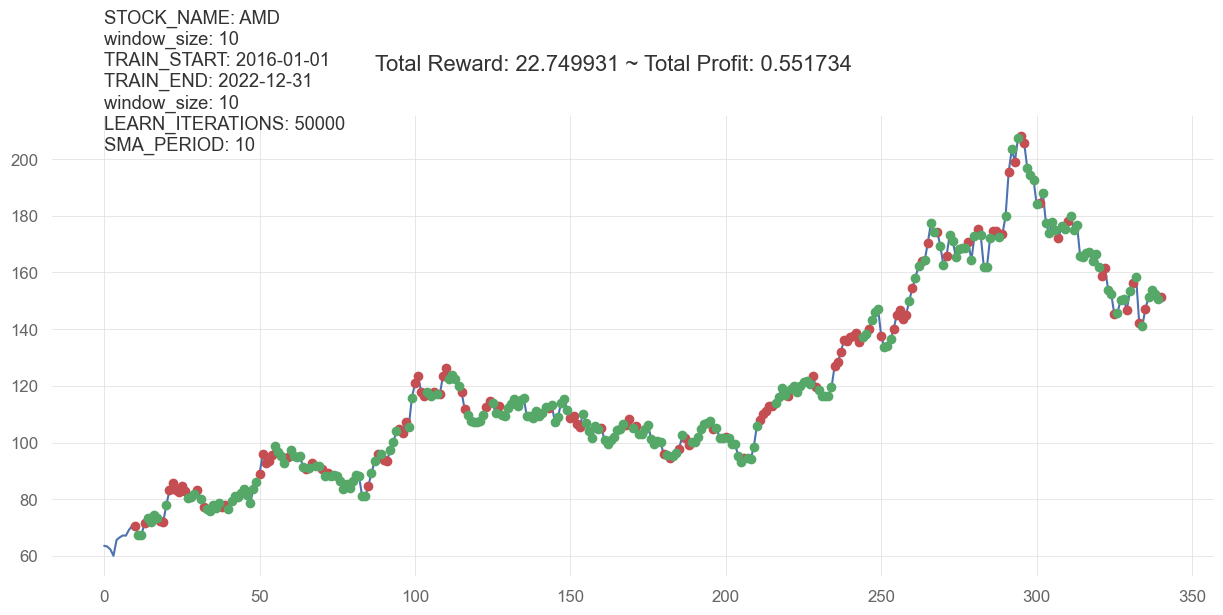

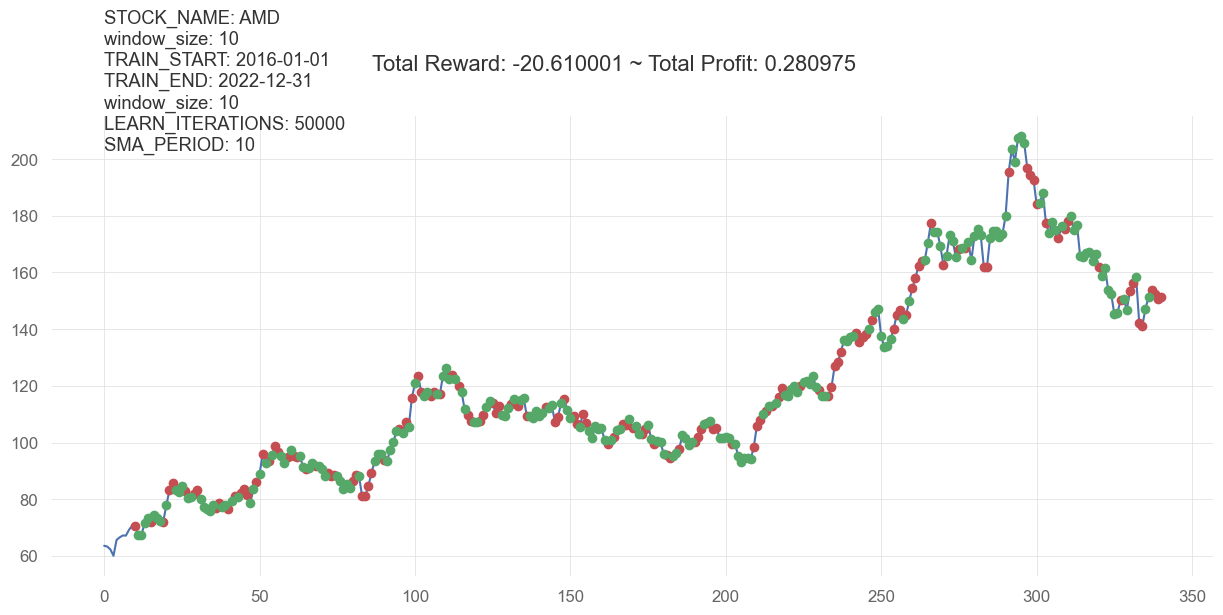

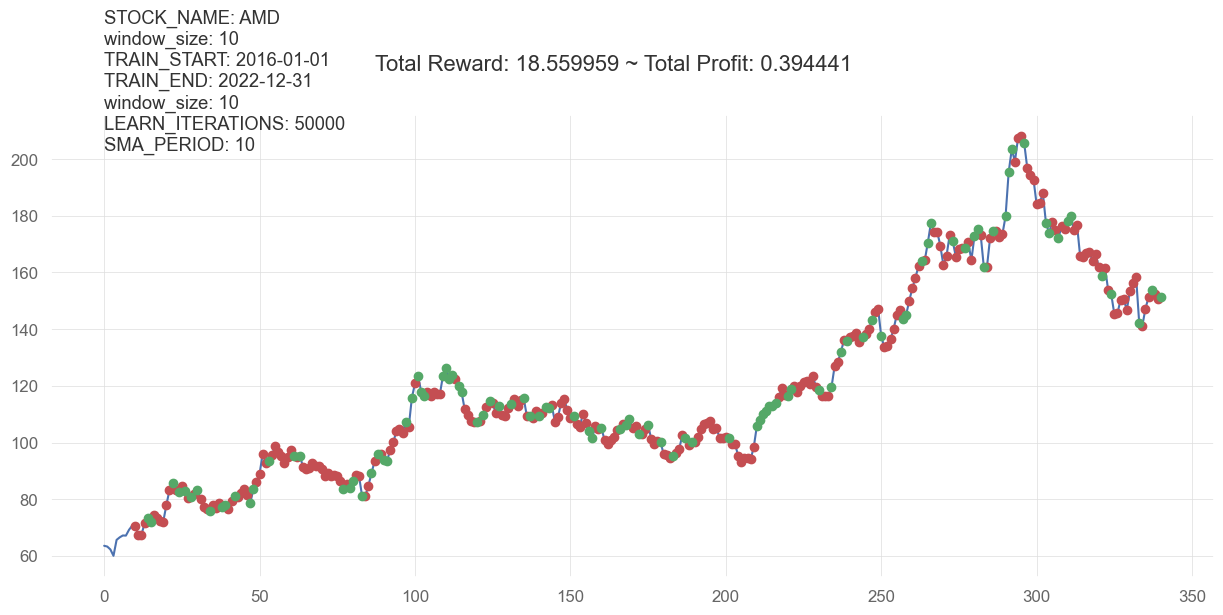

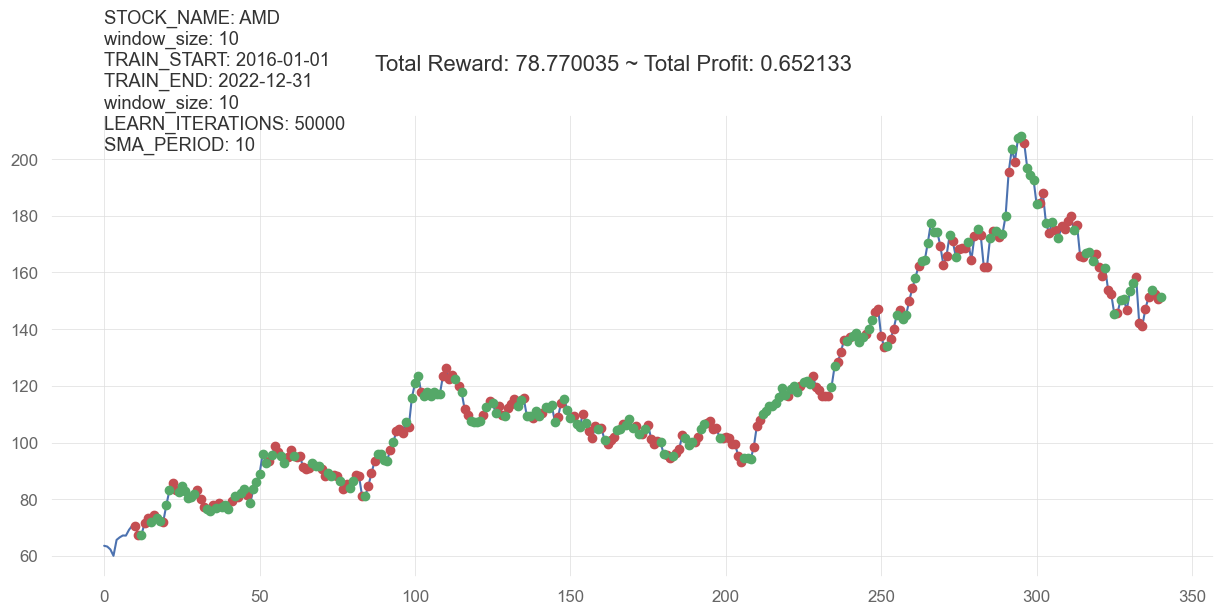

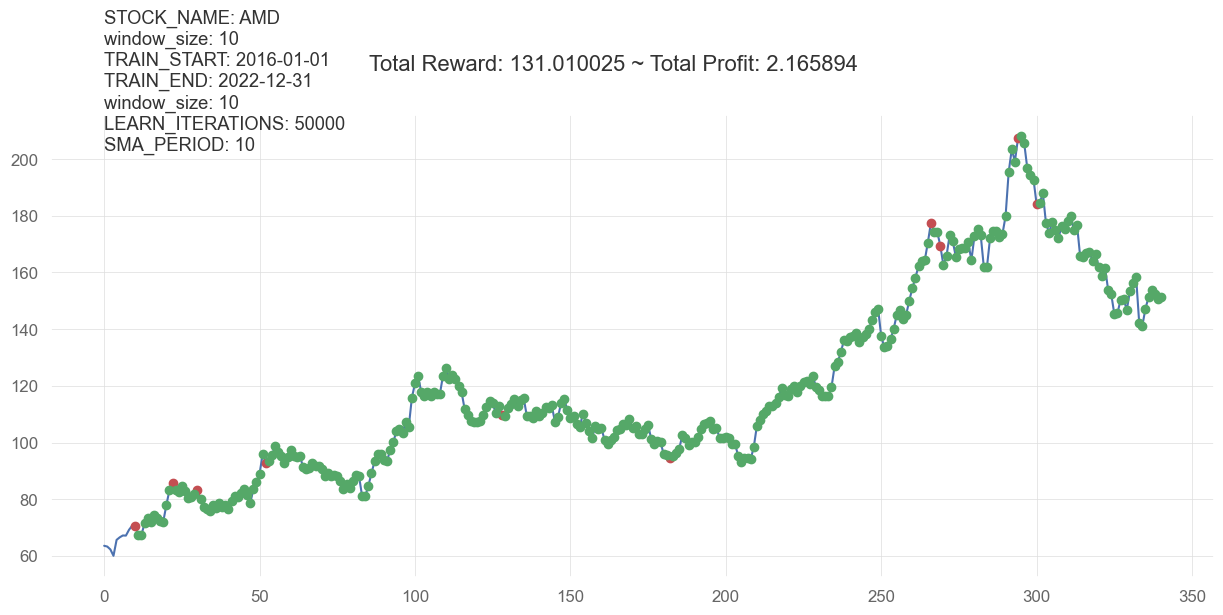

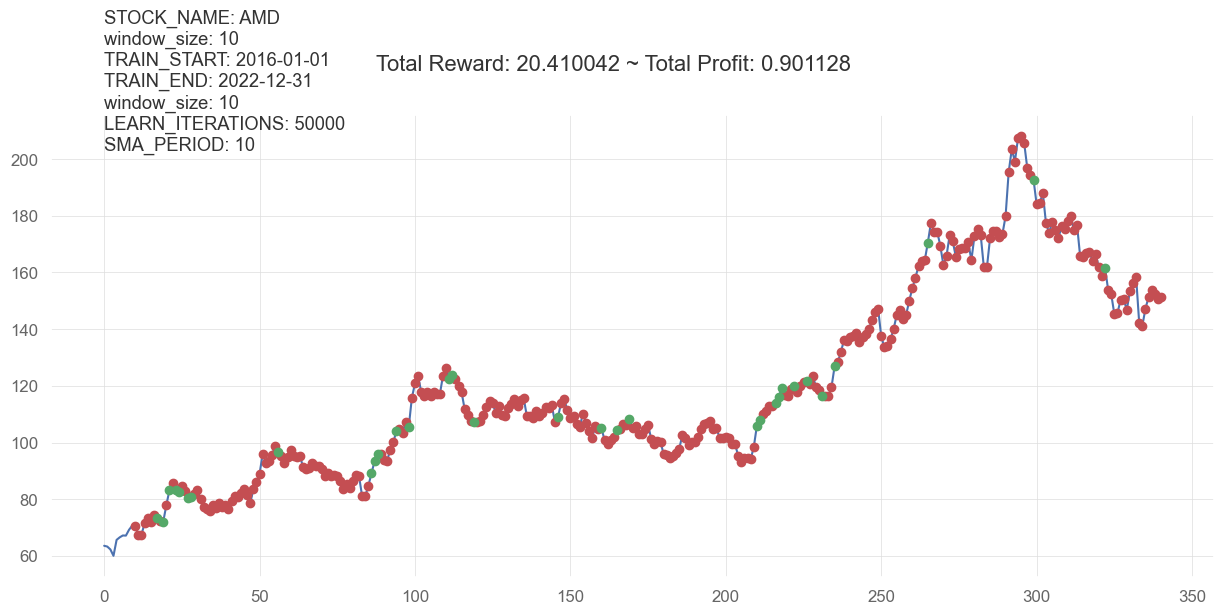

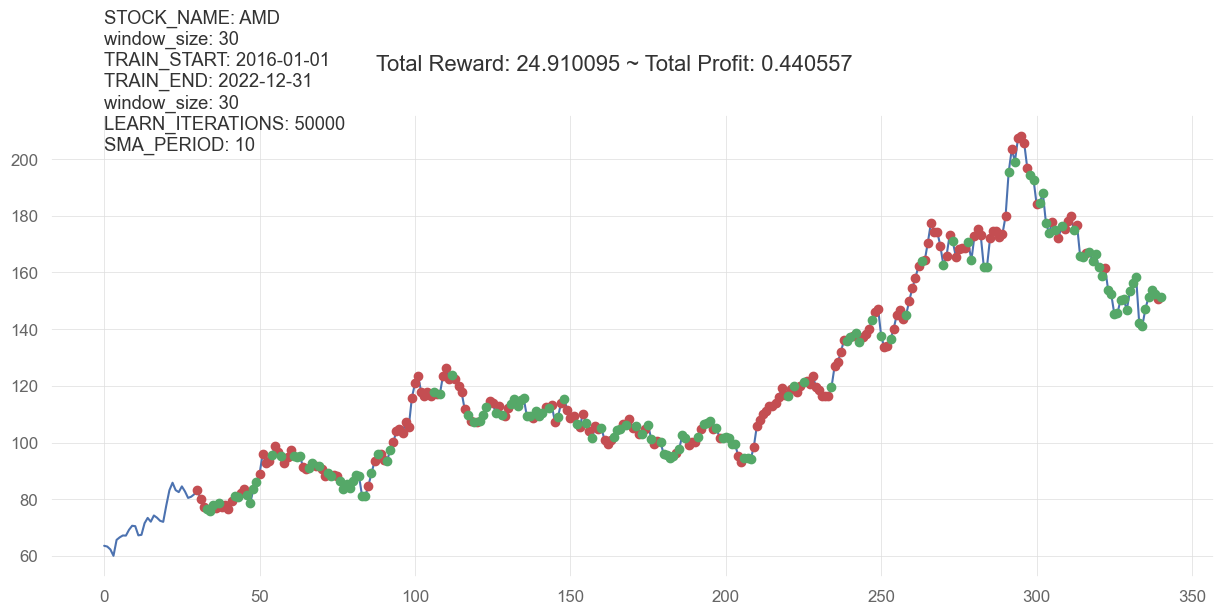

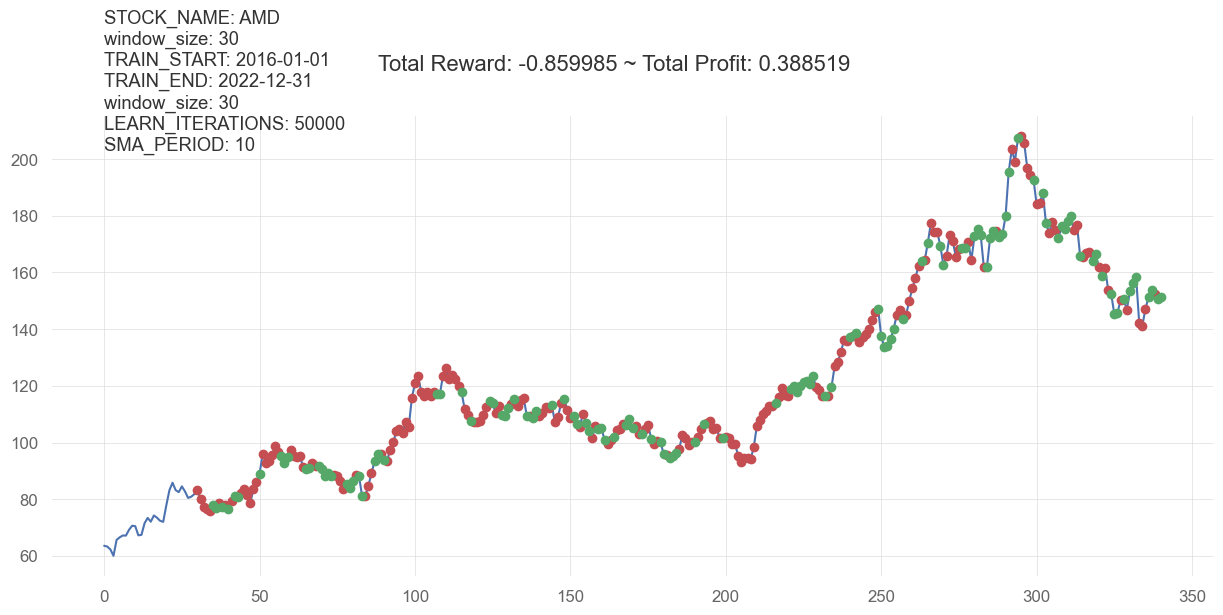

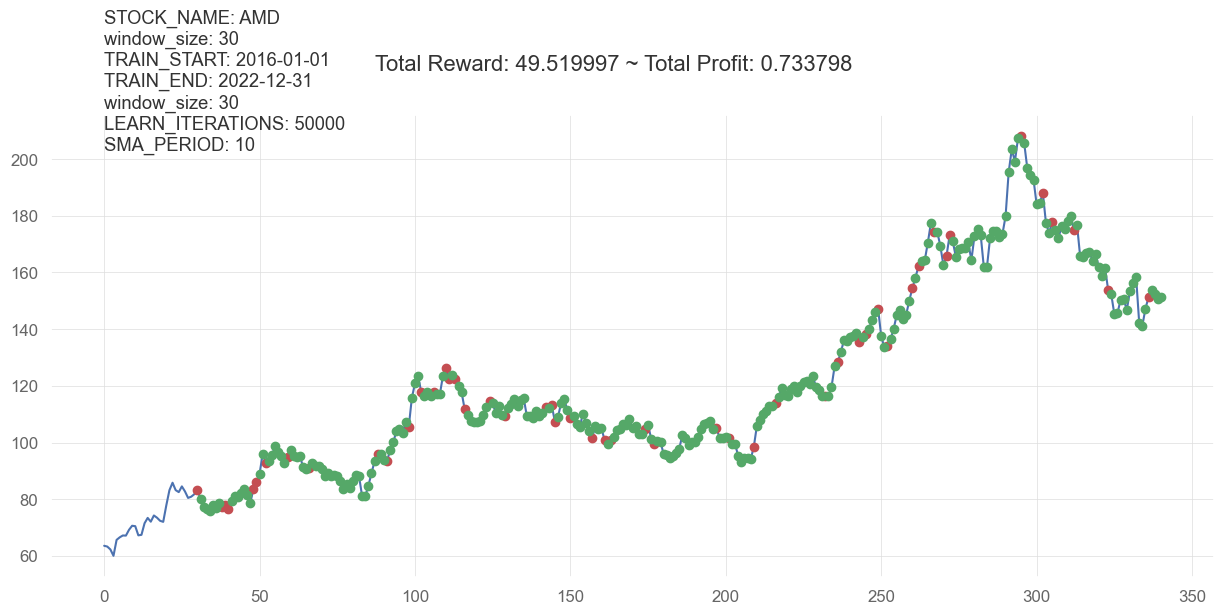

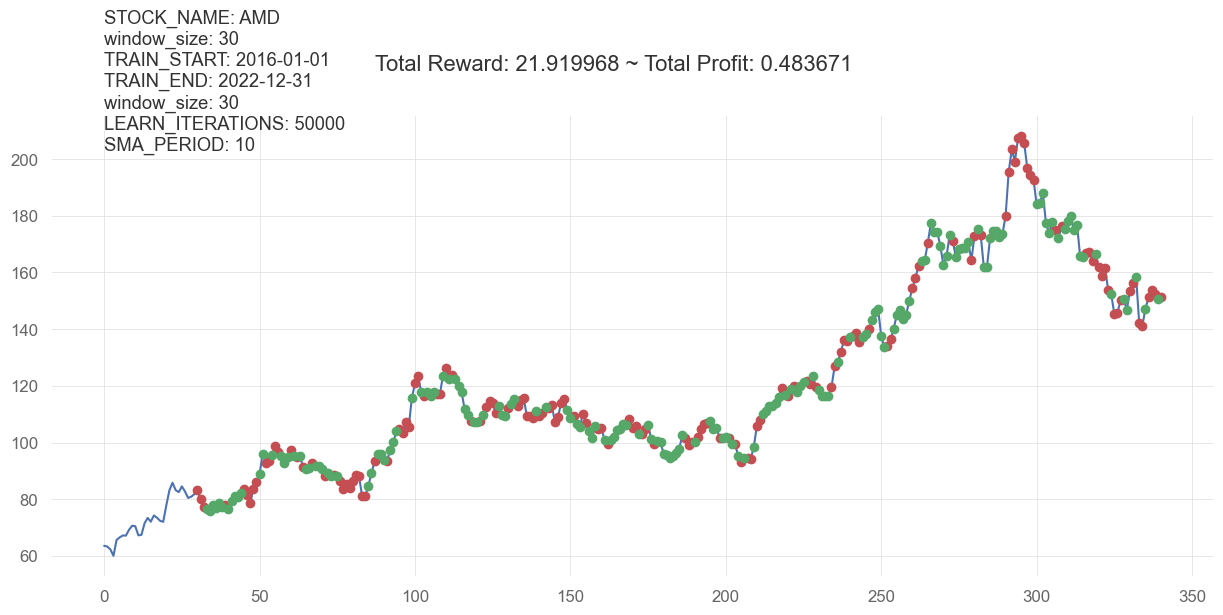

In [28]:
analysis = []
# stock_names = ['NFLX']
# stock_names = ['AMD', 'GL', 'MCD', 'MRO', 'TGT']
stock_names = ['AMD']
for stock_name in stock_names:
    # General settings
    base_settings = {
        'stock_name': stock_name,
        'train_start': '2016-01-01',
        'train_end': '2022-12-31',
        'learn_iteration': 50000,
    }

    # Grid search
    # grid = {
    #     'window_size': [10, 30, 50],
    #     'model_name': ['A2C', 'PPO', 'DQN'],
    #     'add_all': [True, False]
    # }

    grid = {
        'window_size': [10, 30, 50],
        'model_name': ['A2C', 'PPO', 'DQN'],
        'add_all': [True, False]
    }

    if not os.path.exists(stock_name):
        os.makedirs(stock_name)

    # Loop over al grid search combinations
    for values in itertools.product(*grid.values()):
        point = dict(zip(grid.keys(), values))

        # merge the general settings
        settings = {**base_settings, **point}
        analysis.append(analyze_stock(**settings))


In [ ]:
df_analysis = pd.DataFrame(analysis)
df_analysis

,stock_name,window_size,train_start,train_end,learn_iteration,model_name,add_all,total_profit
0,AMD,10,2020-01-01,2022-12-31,50000,A2C,True,0.47
1,AMD,10,2020-01-01,2022-12-31,50000,A2C,False,0.65
2,AMD,10,2020-01-01,2022-12-31,50000,PPO,True,0.53
3,AMD,10,2020-01-01,2022-12-31,50000,PPO,False,0.56
4,AMD,10,2020-01-01,2022-12-31,50000,DQN,True,0.25
5,AMD,10,2020-01-01,2022-12-31,50000,DQN,False,0.73
6,AMD,30,2020-01-01,2022-12-31,50000,A2C,True,0.90
7,AMD,30,2020-01-01,2022-12-31,50000,A2C,False,0.50
8,AMD,30,2020-01-01,2022-12-31,50000,PPO,True,0.43
9,AMD,30,2020-01-01,2022-12-31,50000,PPO,False,0.46


In [ ]:
from typing import List
SEED = 5756
def analyze_stock(
    stock_name: str,
    window_size: int,
    train_start: str,
    train_end: str,
    learn_iteration: str,
    model_name: str
) -> None:
    df = yf.Ticker(stock_name)
    df = df.history(period="max")
    df = df.loc['2020-01-01':, ['Open', 'High', 'Low', 'Close', 'Volume']]
    TRAIN_ENV_FRAME_BOUND = (window_size, df[train_start:train_end].shape[0])
    TEST_ENV_FRAME_BOUND = (df[train_start:train_end].shape[0] + window_size, df.shape[0])


    df_augmented = df.copy()
    df_augmented['SMA'] = TA.SMA(df_augmented, 10)
    df_augmented['RSI'] = TA.RSI(df_augmented)
    df_augmented['OBV'] = TA.OBV(df_augmented)
    df_augmented.fillna(0, inplace=True)

    def add_signals(env):
        start = env.frame_bound[0] - env.window_size
        end = env.frame_bound[1]
        prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
        signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
        return prices, signal_features
    
    class MyCustomEnv(StocksEnv):
        _process_data = add_signals

    env2 = MyCustomEnv(df=df_augmented, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=window_size)
    env_maker = lambda: env2
    env = DummyVecEnv([env_maker])

    if model_name == 'A2C':
        model = A2C('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'RecurrentPPO':
        model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=SEED)
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'PPO':
        model = PPO('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'DQN':
        model = DQN('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)

    env = MyCustomEnv(df=df_augmented, frame_bound=TEST_ENV_FRAME_BOUND, window_size=window_size)
    observation, info = env.reset()
    while True: 
        observation = observation[np.newaxis, ...]
        action, _states = model.predict(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if done:
            print("info", info)
            break
    
    total_profit = round(info['total_profit'], 2)

    # Report output
    trade_strategy_output = f".\\{stock_name}\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{window_size}_ITER{learn_iteration}_trade_strategy.png"
    report_output = f".\\{stock_name}\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{window_size}_ITER{learn_iteration}_reports.html"

    desc = f'STOCK_NAME: {stock_name}\nwindow_size: {window_size}\nTRAIN_START: {train_start}\nTRAIN_END: {train_end}\nwindow_size: {window_size}\nLEARN_ITERATIONS: {learn_iteration}\nSMA_PERIOD: 10'
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.text(0, env.prices.max() - 5, desc)
    plt.savefig(trade_strategy_output)

    qs.extend_pandas()

    net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df_augmented.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
    returns = net_worth.pct_change().iloc[1:]

    qs.reports.html(returns, output=report_output)